Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [28]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [29]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 images belonging to 9 classes.


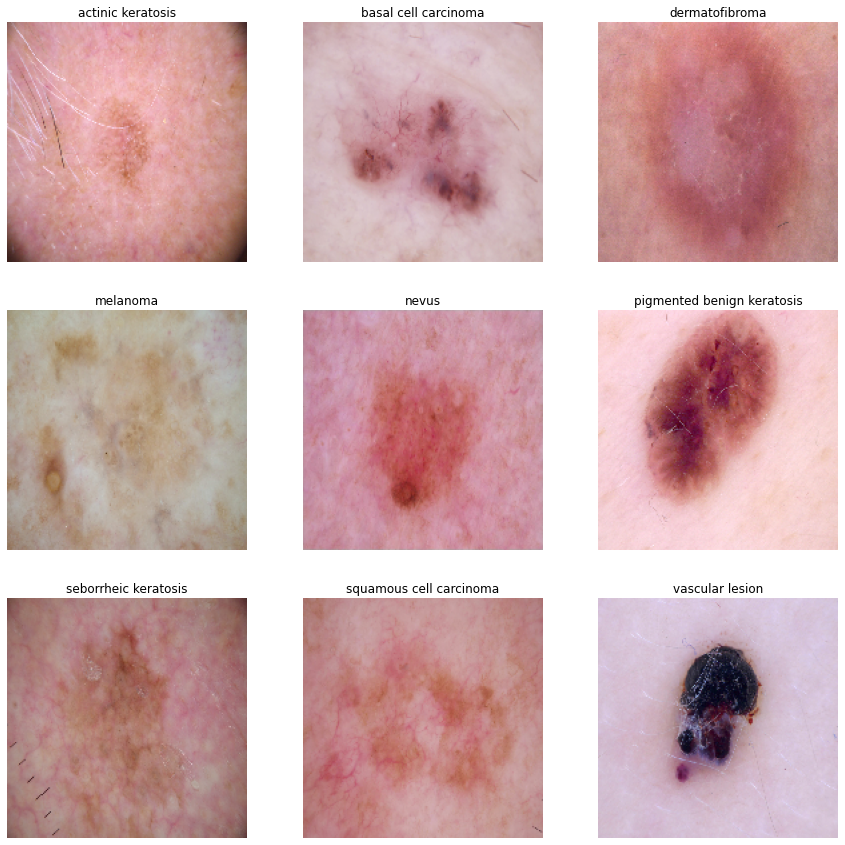

In [10]:
from tensorflow.keras.preprocessing.image import load_img
# Load images from the directory and create a labeled dataset
image_data_generator = ImageDataGenerator(rescale=1./255)
image_dataset = image_data_generator.flow_from_directory(data_dir_train,
                                                          batch_size=32,
                                                          target_size=(180, 180),
                                                          class_mode='categorical',
                                                          seed=123)

# Get class names from the dataset
class_names = image_dataset.class_indices.keys()

# Dictionary to store the file paths of images for each class
class_files_dict = {}

# Populate the dictionary with file paths
for class_name in class_names:
    class_files_dict[class_name] = [os.path.join(data_dir_train, class_name, file) for file in os.listdir(os.path.join(data_dir_train, class_name))]

# Visualize one image per class
plt.figure(figsize=(15, 15))
for i, class_name in enumerate(class_names, 1):
    file_path = class_files_dict[class_name][0]
    
    # Set up subplots for each class
    plt.subplot(3, 3, i)
    
    # Load and display the image
    img = load_img(file_path, target_size=(180, 180))
    plt.imshow(img)
    
    # Set subplot title and turn off axis
    plt.title(class_name)
    plt.axis("off")

# Display the plot
plt.show()


# Class Distribution

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# CNN Model Architecture

# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale pixel values to the range [0,1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with a 50% fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with a 25% fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales numbers/logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint Callback
# Save the model or weights at intervals during training based on a monitored metric (here, validation accuracy).
# Helps create checkpoints to later load the best-performing model for further analysis or deployment.
checkpoint = ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping Callback
# Stop training when a monitored metric (here, validation accuracy) stops improving.
# Prevents overfitting and saves time by ending training early if performance plateaus.
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)


In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 45s 668ms/step - loss: 1.9942 - accuracy: 0.2517 - val_loss: 1.7998 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 36s 633ms/step - loss: 1.7772 - accuracy: 0.3443 - val_loss: 1.5881 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 35s 630ms/step - loss: 1.6156 - accuracy: 0.4241 - val_loss: 1.5332 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 35s 628ms/step - loss: 1.5152 - accuracy: 0.4743 - val_loss: 1.4783 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 35s 628ms/step - loss: 1.4354 - accuracy: 0.4983 - val_loss: 1.4409 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 36s 635ms/step - loss: 1.3932 - accuracy: 0.5234 - val_loss: 1.4821 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 37s 669ms/step - loss: 1.3834 - accuracy: 0.5033 - val_loss: 1.4021 - val_accuracy: 0.5168
Epoch 8/20

### Visualizing training results

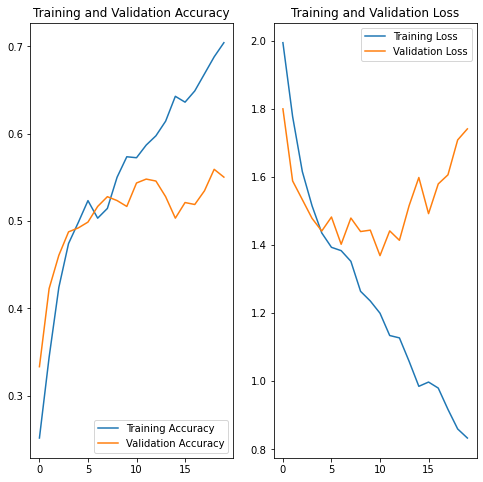

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

# Observations:
- We can see the model is  overrfit as  Training error is low and test error is  high as compared to train.

### Write your findings here

In [23]:
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen_params = {
    'rotation_range': 10,
    'zoom_range': 0.1,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': False,
    'vertical_flip': False,
    'featurewise_center': False,
    'samplewise_center': False,
    'featurewise_std_normalization': False,
    'samplewise_std_normalization': False,
    'zca_whitening': False,
}

# Create ImageDataGenerator
datagen = ImageDataGenerator(**datagen_params)

# Define image classes
image_classes = ['nevus', 'melanoma', 'basal_cell_carcinoma', 'actinic_keratosis', 'vascular_lesion',
                 'dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carcinoma']

# Define data directories
data_dir_train = "train"
data_dir_test = "test"

# Create data generators for training and validation
train_batches = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    classes=image_classes,
    batch_size=64
)

valid_batches = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    classes=image_classes,
    batch_size=64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


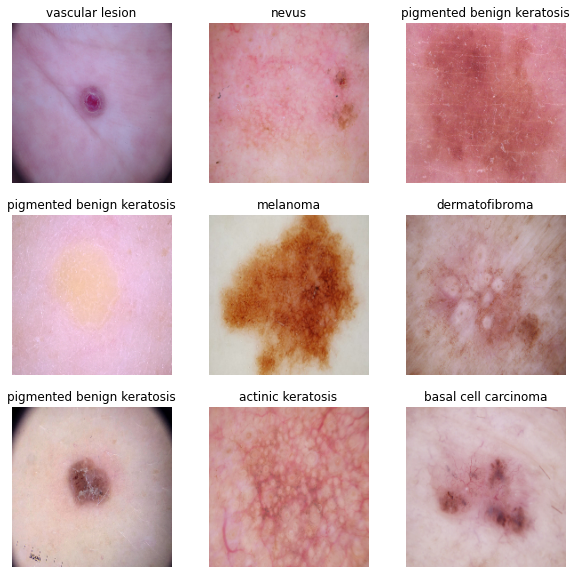

In [30]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
import matplotlib.pyplot as plt


def visualize_augmentation(train_dataset, class_names, num_samples=9):
    plt.figure(figsize=(10, 10))

    for images, labels in train_dataset.take(1):
        
        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.show()

# Assuming you have a 'train_ds' dataset and 'class_names' list defined
visualize_augmentation(train_ds, class_names)


### Todo:
### Create the model, compile and train the model


In [31]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
# CNN Model Architecture

# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale pixel values to the range [0,1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with a 50% fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with a 25% fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales numbers/logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Compiling the model

In [32]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 50s 864ms/step - loss: 2.0442 - accuracy: 0.2494 - val_loss: 1.7742 - val_accuracy: 0.4094
Epoch 2/30
56/56 [==============================] - 53s 929ms/step - loss: 1.7160 - accuracy: 0.3828 - val_loss: 1.5511 - val_accuracy: 0.4787
Epoch 3/30
56/56 [==============================] - 51s 881ms/step - loss: 1.5301 - accuracy: 0.4587 - val_loss: 1.4624 - val_accuracy: 0.5280
Epoch 4/30
56/56 [==============================] - 48s 827ms/step - loss: 1.4587 - accuracy: 0.4905 - val_loss: 1.4731 - val_accuracy: 0.5011
Epoch 5/30
56/56 [==============================] - 48s 828ms/step - loss: 1.3991 - accuracy: 0.5084 - val_loss: 1.3776 - val_accuracy: 0.5213
Epoch 6/30
56/56 [==============================] - 49s 862ms/step - loss: 1.3136 - accuracy: 0.5268 - val_loss: 1.4416 - val_accuracy: 0.4832
Epoch 7/30
56/56 [==============================] - 48s 842ms/step - loss: 1.3519 - accuracy: 0.5201 - val_loss: 1.3620 - val_accuracy: 0.5369

### Visualizing the results

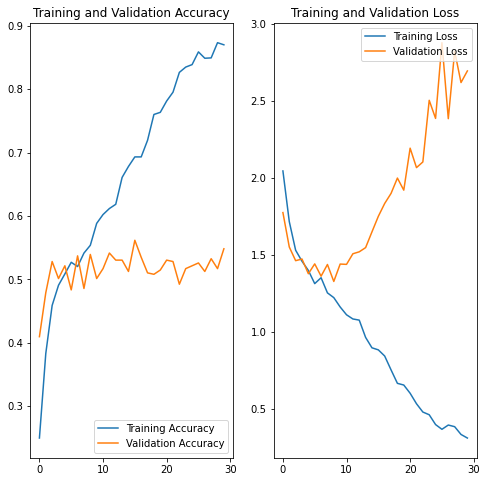

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# Observations :
- The model is overfitted.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

# Class Distribution

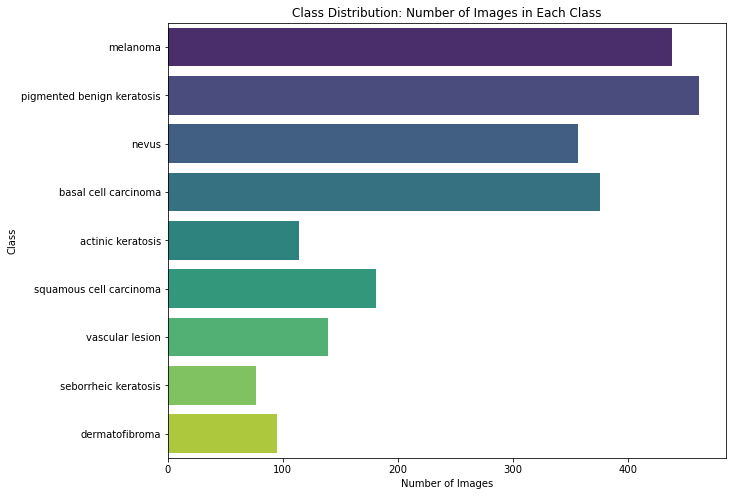

The class with the highest contribution is: melanoma


In [36]:
import seaborn as sns
# Count the number of images in each class
count = []
sub_directory = []

for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        sub_directory.append(path.name)
        count.append(len([name for name in os.listdir(path)
                           if os.path.isfile(os.path.join(path, name))]))

# Create a DataFrame with image count and class
df = pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])

# Visualize the number of images in each class using a horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, palette="viridis")
plt.title("Class Distribution: Number of Images in Each Class")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.show()
# Print the class with the highest contribution
highest_contributing_class = df.iloc[0]['Class']
print(f"The class with the highest contribution is: {highest_contributing_class}")


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


# Observations:
- Class seborrheic has least number of sample.
- Melanamo has highest proportion.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8EFD228F70>: 100%


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8EFBD77220>: 100%


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8EFBDB7F70>: 100%


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F8EF7EC5940>: 10


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8FF70B5610>: 100


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8EFBD768E0>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

# Total Number of images generated by Augmentor.

In [39]:
import pathlib

# Path to the augmented training data directory
augmented_data_dir_train = pathlib.Path("Train")

# Counting the total number of augmented images generated by Augmentor
augmented_image_count_train = len(list(augmented_data_dir_train.glob('*/output/*.jpg')))

# Printing the total count of augmented images in the training dataset
print("Total number of augmented images in the training dataset:", augmented_image_count_train)


Total number of augmented images in the training dataset: 4500


#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
data_dir_train="Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
# CNN Model Architecture

# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Sequential allows you to create models layer-by-layer
model = Sequential()

# Rescaling Layer: Scale pixel values to the range [0,1]
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with a 50% fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer: Flatten the multi-dimensional input tensors into a single dimension
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with a 25% fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
# Softmax scales numbers/logits into probabilities
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display the model summary
model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 130s 766ms/step - loss: 1.9186 - accuracy: 0.2697 - val_loss: 1.5823 - val_accuracy: 0.4157
Epoch 2/30
169/169 [==============================] - 139s 816ms/step - loss: 1.5309 - accuracy: 0.4208 - val_loss: 1.4014 - val_accuracy: 0.4684
Epoch 3/30
169/169 [==============================] - 140s 823ms/step - loss: 1.3695 - accuracy: 0.4850 - val_loss: 1.2714 - val_accuracy: 0.5338
Epoch 4/30
169/169 [==============================] - 141s 827ms/step - loss: 1.2411 - accuracy: 0.5332 - val_loss: 1.1334 - val_accuracy: 0.5835
Epoch 5/30
169/169 [==============================] - 141s 830ms/step - loss: 1.1787 - accuracy: 0.5601 - val_loss: 1.1355 - val_accuracy: 0.5664
Epoch 6/30
169/169 [==============================] - 143s 841ms/step - loss: 1.0316 - accuracy: 0.6193 - val_loss: 1.0068 - val_accuracy: 0.6110
Epoch 7/30
169/169 [==============================] - 143s 843ms/step - loss: 0.9646 - accuracy: 0.6422 - val_loss: 1.1236 - val_accura

#### **Todo:**  Visualize the model results

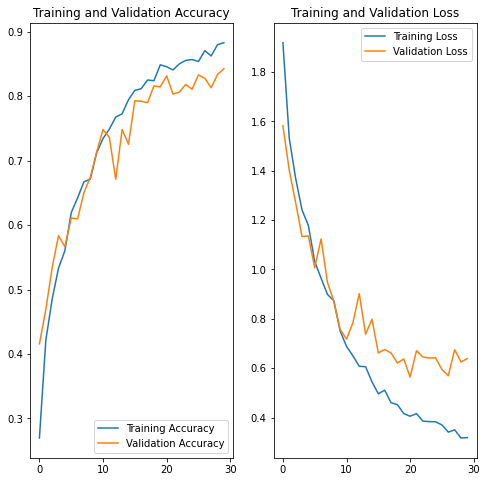

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Observations :
- The final model after using 'Augmentor' is giving the generalized model. 
- It has low variance and low bias